In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta
from datetime import datetime
from sklearn.model_selection import train_test_split

In [2]:
ticker = 'NFLX'
benchmark = 'SPY'
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)
data = yf.download([ticker,benchmark], start, end)

df = pd.DataFrame(index = data.index)
data.head(5)


*********************100%***********************]  2 of 2 completed

Price        Adj Close                   Close                    High  \
Ticker            NFLX         SPY        NFLX         SPY        NFLX   
Date                                                                     
2024-02-07  559.299988  491.791626  559.299988  498.100006  567.799988   
2024-02-08  558.530029  492.008820  558.530029  498.320007  563.700012   
2024-02-09  561.320007  494.852417  561.320007  501.200012  566.000000   
2024-02-12  557.849976  494.635193  557.849976  500.980011  568.440002   
2024-02-13  554.520020  487.822571  554.520020  494.079987  559.200012   

Price                          Low                    Open              \
Ticker             SPY        NFLX         SPY        NFLX         SPY   
Date                                                                     
2024-02-07  498.529999  554.979980  495.359985  558.159973  496.290009   
2024-02-08  498.709991  555.739990  497.260010  560.549988  498.100006   
2024-02-09  501.649994  558.099976  498.489990  565.000000  498.839996   
2024-02-12  503.500000  557.000000  500.239990  560.359985  501.170013   
2024-02-13  497.089996  549.000000  490.720001  550.799988  494.529999   

Price        Volume             
Ticker         NFLX        SPY  
Date                            
2024-02-07  4373600   70556500  
2024-02-08  3175500   52343600  
2024-02-09  3055700   63979400  
2024-02-12  3608500   56502300  
2024-02-13  3511500  113099200

In [3]:
# Calculate EMA (Exponential Moving Average)
df['EMA10'] = ta.trend.ema_indicator(data['Close', ticker], window=10)
df['EMA30'] = ta.trend.ema_indicator(data['Close', ticker], window=30)

# Calculate ATR (Average True Range)
df['ATR'] = ta.volatility.average_true_range(data['High', ticker], data['Low', ticker], data['Close', ticker], window=14)

# Calculate ADX (Average Directional Index)
df['ADX'] = ta.trend.adx(data['High', ticker], data['Low', ticker], data['Close', ticker], window=14)

# Calculate RSI (Relative Strength Index)
df['RSI'] = ta.momentum.rsi( data['Close', ticker], window=14)

# Calculate MACD (Moving Average Convergence Divergence)
df['MACD'] = ta.trend.macd( data['Close', ticker], window_slow=26, window_fast=12)

# Calculate MACD Signal line
df['MACD_signal'] = ta.trend.macd_signal( data['Close', ticker], window_slow=26, window_fast=12, window_sign=9)

df.shape[0]

252

# Introduce features

In [4]:
df['Close_EMA_10'] = np.where(data['Close', ticker]> df['EMA10'], 1, -1)
df['EMA_10_EMA_30'] = np.where(df['EMA10'] > df['EMA30'], 1, -1)
df['MACD_Signal_MACD'] = np.where(df['MACD_signal'] > df['MACD'], 1, -1)

df.tail(11)

,EMA10,EMA30,ATR,ADX,RSI,MACD,MACD_signal,Close_EMA_10,EMA_10_EMA_30,MACD_Signal_MACD
Date,,,,,,,,,,
2025-01-24,911.637094,890.248703,30.979788,30.655929,69.746680,13.334118,0.901699,1,1,-1
2025-01-27,922.592170,895.515884,30.339089,31.287883,67.948489,17.556190,4.232597,1,1,-1
2025-01-28,931.544506,900.439376,29.645583,31.717147,67.928637,20.659225,7.517923,1,1,-1
2025-01-29,940.018237,905.452967,28.914472,32.352682,68.957490,23.359104,10.686159,1,1,-1
2025-01-30,946.058555,909.826323,28.604868,33.109016,67.155028,24.816511,13.512229,1,1,-1
2025-01-31,951.640638,914.144625,27.779520,33.811325,67.804741,25.956343,16.001052,1,1,-1
2025-02-03,956.604159,918.324972,27.460268,33.859299,68.223966,26.727478,18.146337,1,1,-1
2025-02-04,963.561584,923.263361,27.605248,34.458799,71.177440,28.297825,20.176635,1,1,-1
2025-02-05,972.206748,928.930885,27.429875,35.112479,73.846276,30.501170,22.241542,1,1,-1


<h2>Creating the target variables</h2>
This are the variables whose values are to be modeled and predicted by othervariables. There must be one and only one target variable in a decision tree analysis.
The target variable for the classification algorithm also uses the lagged return, butbecause the output is categorical, we must transform it. If the return was positive,we assign 1 and if it was negative, we assign 0.

In [5]:
df['returned'] = np.log(data['Close', ticker]/data['Close', ticker].shift(1))
df['return_'+benchmark] = np.log(data['Close', benchmark]/data['Close', benchmark].shift(1))
df['target'] = np.where(df['returned'] > 0, 1, 0)

df

,EMA10,EMA30,ATR,ADX,RSI,MACD,MACD_signal,Close_EMA_10,EMA_10_EMA_30,MACD_Signal_MACD,returned,return_SPY,target
Date,,,,,,,,,,,,,
2024-02-07,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,-1,-1,-1,NaN,NaN,0
2024-02-08,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,-1,-1,-1,-0.001378,0.000442,0
2024-02-09,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,-1,-1,-1,0.004983,0.005763,1
2024-02-12,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,-1,-1,-1,-0.006201,-0.000439,0
2024-02-13,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,-1,-1,-1,-0.005987,-0.013869,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-03,956.604159,918.324972,27.460268,33.859299,68.223966,26.727478,18.146337,1,1,-1,0.002229,-0.006752,1
2025-02-04,963.561584,923.263361,27.605248,34.458799,71.177440,28.297825,20.176635,1,1,-1,0.016142,0.006686,1
2025-02-05,972.206748,928.930885,27.429875,35.112479,73.846276,30.501170,22.241542,1,1,-1,0.016192,0.004046,1


In [6]:
X = df[['ATR', 'ADX','RSI', 'Close_EMA_10', 'EMA_10_EMA_30', 'MACD_Signal_MACD']] #features
y = df.target #target

X_clean = X.dropna()
Y_clean = y[X.index.isin(X_clean.index)]

X=X_clean
y=Y_clean

#splitting the data and building the training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [7]:
df.describe()

,EMA10,EMA30,ATR,ADX,RSI,MACD,MACD_signal,Close_EMA_10,EMA_10_EMA_30,MACD_Signal_MACD,returned,return_SPY,target
count,243.000000,223.000000,252.000000,252.000000,239.000000,227.000000,219.000000,252.000000,252.000000,252.000000,251.000000,251.000000,252.000000
mean,709.904628,705.471101,16.624100,25.133791,58.312637,10.396743,10.098393,0.333333,0.436508,-0.111111,0.002413,0.000765,0.527778
std,113.695286,102.383647,5.196597,11.786776,11.489131,12.659833,11.445106,0.944685,0.901491,0.995786,0.018323,0.008029,0.500221
min,566.779196,586.652880,0.000000,0.000000,27.567025,-15.799501,-11.780083,-1.000000,-1.000000,-1.000000,-0.095336,-0.030257,0.000000
25%,621.592250,626.685154,14.840340,18.276509,52.338099,4.182385,4.127377,-1.000000,-1.000000,-1.000000,-0.007189,-0.003032,0.000000
50%,674.519597,664.358255,16.625708,26.178103,59.881166,10.769755,10.117040,1.000000,1.000000,-1.000000,0.002325,0.001103,1.000000
75%,768.221640,765.274283,18.746858,34.022271,66.165215,14.764724,13.789255,1.000000,1.000000,1.000000,0.012862,0.005748,1.000000
max,988.241698,940.353560,31.996084,45.638767,82.260471,39.707412,36.449067,1.000000,1.000000,1.000000,0.105144,0.024561,1.000000


Import all machine learning models

In [8]:
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

In [9]:
def plot_models(results, names):
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

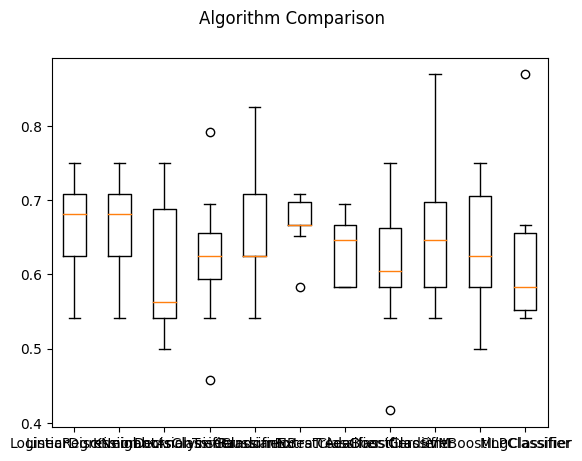

In [10]:
seed = 7
models = []

models.append(('LogisticRegression', LogisticRegression(random_state=seed)))
models.append(('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()))
models.append(('KNeighborsClassifier', KNeighborsClassifier()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('GaussianNB', GaussianNB()))
models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('ExtraTreesClassifier',ExtraTreesClassifier(random_state=seed)))
models.append(('AdaBoostClassifier',AdaBoostClassifier(DecisionTreeClassifier(random_state=seed),random_state=seed,learning_rate=0.1)))
models.append(('SVM',svm.SVC(random_state=seed)))
models.append(('GradientBoostingClassifier',GradientBoostingClassifier(random_state=seed)))
models.append(('MLPClassifier',MLPClassifier(random_state=seed)))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    #print(msg) 

#print(results, names)
plot_models(results, names)

# Hyper-parameter Tuning

In [11]:
param_grid={
    'n_estimators':[100,200,300],
    'max_depth':[10,20,30],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4]
}

In [12]:
#for name, model in models:
    #grid_search = GridSearchCV(estimator = model, param_grid = param_grid,cv = 3, n_jobs = -1, verbose = 2)
grid_search = GridSearchCV(estimator = RandomForestClassifier(random_state=42), param_grid = param_grid,cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

best_params=grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")
best_model=RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train,y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=200, random_state=42)

# Performance Evaluation

In [13]:
y_pred=best_model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.61      0.58      0.59        33
           1       0.66      0.69      0.68        39

    accuracy                           0.64        72
   macro avg       0.64      0.63      0.63        72
weighted avg       0.64      0.64      0.64        72



In [14]:
accuracy=accuracy_score(y_test,y_pred)
print(f"Accuracy:{accuracy}")

Accuracy:0.6388888888888888


In [15]:
df.head(5)

,EMA10,EMA30,ATR,ADX,RSI,MACD,MACD_signal,Close_EMA_10,EMA_10_EMA_30,MACD_Signal_MACD,returned,return_SPY,target
Date,,,,,,,,,,,,,
2024-02-07,NaN,NaN,0.0,0.0,NaN,NaN,NaN,-1,-1,-1,NaN,NaN,0
2024-02-08,NaN,NaN,0.0,0.0,NaN,NaN,NaN,-1,-1,-1,-0.001378,0.000442,0
2024-02-09,NaN,NaN,0.0,0.0,NaN,NaN,NaN,-1,-1,-1,0.004983,0.005763,1
2024-02-12,NaN,NaN,0.0,0.0,NaN,NaN,NaN,-1,-1,-1,-0.006201,-0.000439,0
2024-02-13,NaN,NaN,0.0,0.0,NaN,NaN,NaN,-1,-1,-1,-0.005987,-0.013869,0


In [16]:
df.columns

Index(['EMA10', 'EMA30', 'ATR', 'ADX', 'RSI', 'MACD', 'MACD_signal',
       'Close_EMA_10', 'EMA_10_EMA_30', 'MACD_Signal_MACD', 'returned',
       'return_SPY', 'target'],
      dtype='object')

Plot graph to check which strategy is working

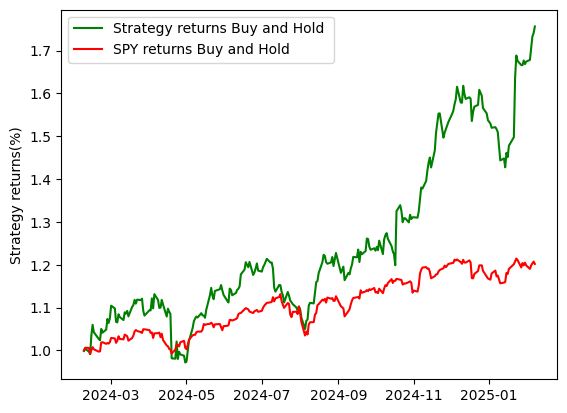

[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total 

In [17]:
train_length=0
#plt.plot((df.strategy_returns[train_length:]+1).cumprod(),'b-',label='Strategy returns decision tree ')
plt.plot((df.returned[train_length:]+1).cumprod(),'g-',label='Strategy returns Buy and Hold ')
plt.plot((df['return_'+benchmark][train_length:]+1).cumprod(),'r-',label=benchmark+' returns Buy and Hold ')
plt.ylabel('Strategy returns(%)')
plt.legend()
plt.show()